In [41]:
import torch
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split

In [42]:
class ShapesDatasets(Dataset):
    def __init__(self, root_dir, transform=None):
        self.datasets = datasets.ImageFolder(root=root_dir, transform=transform)
    
    def __len__(self):
        return len(self.datasets)
    
    def __getitem__(self, idx):
        return self.datasets[idx]

In [43]:
transform = transforms.Compose([
    transforms.Resize((28, 28)),

    transforms.RandomHorizontalFlip(p=0.5),

    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [44]:
file_path = "./Datasets/shapes/"
dataset = ShapesDatasets(root_dir=file_path, transform=transform)

In [45]:
len(dataset)

300

In [46]:
train_indices, test_indices = train_test_split(range(len(dataset)), test_size=0.2, random_state=42)
train_indices[:5], test_indices[:5]

([232, 59, 6, 185, 173], [203, 266, 152, 9, 233])

In [47]:
import torch.utils
import torch.utils.data


train_loader = DataLoader(dataset, batch_size=16, sampler=torch.utils.data.RandomSampler(train_indices))

test_loader = DataLoader(dataset, batch_size=16, sampler=torch.utils.data.SequentialSampler(test_indices))

In [48]:
for images, labels in train_loader:
    print("Batch images shapes: ", images.shape)
    print("Batch labels shapes: ", labels.shape)

Batch images shapes:  torch.Size([16, 3, 28, 28])
Batch labels shapes:  torch.Size([16])
Batch images shapes:  torch.Size([16, 3, 28, 28])
Batch labels shapes:  torch.Size([16])
Batch images shapes:  torch.Size([16, 3, 28, 28])
Batch labels shapes:  torch.Size([16])
Batch images shapes:  torch.Size([16, 3, 28, 28])
Batch labels shapes:  torch.Size([16])
Batch images shapes:  torch.Size([16, 3, 28, 28])
Batch labels shapes:  torch.Size([16])
Batch images shapes:  torch.Size([16, 3, 28, 28])
Batch labels shapes:  torch.Size([16])
Batch images shapes:  torch.Size([16, 3, 28, 28])
Batch labels shapes:  torch.Size([16])
Batch images shapes:  torch.Size([16, 3, 28, 28])
Batch labels shapes:  torch.Size([16])
Batch images shapes:  torch.Size([16, 3, 28, 28])
Batch labels shapes:  torch.Size([16])
Batch images shapes:  torch.Size([16, 3, 28, 28])
Batch labels shapes:  torch.Size([16])
Batch images shapes:  torch.Size([16, 3, 28, 28])
Batch labels shapes:  torch.Size([16])
Batch images shapes: 

In [49]:
index = torch.randint(len(dataset), size=(1,)).item()
index

215

In [50]:
import matplotlib.pyplot as plt

In [51]:
image, label = dataset[index]
label, image.shape

(2, torch.Size([3, 28, 28]))

In [52]:
image = image.permute(1,2,0).numpy()
image.shape

(28, 28, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


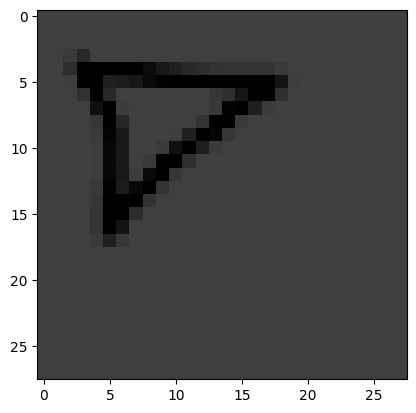

In [53]:
plt.imshow(0.5 * image * 0.5)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

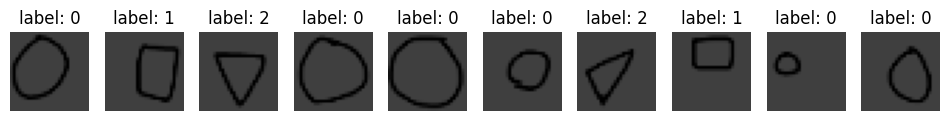

In [54]:
def show_samples(dataset, num_samples=5):
    fig, axes = plt.subplots(1, num_samples, figsize=(12,2))

    for i in range(num_samples):
        index = torch.randint(len(dataset), size=(1,)).item()
        image, label = dataset[index]
        image = image.permute(1, 2, 0).numpy()
        image = 0.5 * image * 0.5
        axes[i].imshow(image)
        axes[i].set_title(f"label: {label}")
        axes[i].axis('off')
    plt.show()

show_samples(dataset, 10)

In [55]:
import torch
import torch.nn as nn
import torch.optim as optim

In [56]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        self.fc1 = nn.Linear(32 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 3)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.pool(x)

        x = self.conv2(x)
        x = torch.relu(x)
        x = self.pool(x)

        x = x.view(-1, 32 * 7 * 7)
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)
        return x

model = CNN()
scripted_model = torch.jit.script(model)

scripted_model.save('final_model_scripted.pth')
print("Model saved in TorchScript format.")

Model saved in TorchScript format.


In [57]:
model = CNN()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_losses = []
test_losses = []

In [58]:
epochs = 50

for epoch in range(epochs):
    # Training
    epoch_train_loss = 0.0
    epoch_test_loss = 0.0

    for i, (images, labels) in enumerate(train_loader):
        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()

    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            epoch_test_loss += loss.item()

    
    train_loss = epoch_train_loss / len(train_loader)
    test_loss = epoch_test_loss / len(test_loader)
    print(f"Eochs [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")
    train_losses.append(train_loss)
    test_losses.append(test_loss)

Eochs [1/50], Train Loss: 1.0486, Test Loss: 0.9554
Eochs [2/50], Train Loss: 0.9978, Test Loss: 0.9217
Eochs [3/50], Train Loss: 0.9139, Test Loss: 0.6489
Eochs [4/50], Train Loss: 0.8107, Test Loss: 0.4502
Eochs [5/50], Train Loss: 0.6852, Test Loss: 0.2750
Eochs [6/50], Train Loss: 0.5929, Test Loss: 0.3488
Eochs [7/50], Train Loss: 0.4600, Test Loss: 0.3435
Eochs [8/50], Train Loss: 0.4165, Test Loss: 0.2590
Eochs [9/50], Train Loss: 0.3340, Test Loss: 0.2266
Eochs [10/50], Train Loss: 0.2520, Test Loss: 0.1379
Eochs [11/50], Train Loss: 0.1932, Test Loss: 0.1345
Eochs [12/50], Train Loss: 0.1678, Test Loss: 0.1271
Eochs [13/50], Train Loss: 0.1385, Test Loss: 0.1374
Eochs [14/50], Train Loss: 0.0903, Test Loss: 0.0670
Eochs [15/50], Train Loss: 0.0938, Test Loss: 0.0481
Eochs [16/50], Train Loss: 0.0596, Test Loss: 0.0161
Eochs [17/50], Train Loss: 0.0658, Test Loss: 0.0593
Eochs [18/50], Train Loss: 0.0569, Test Loss: 0.0630
Eochs [19/50], Train Loss: 0.0388, Test Loss: 0.0211
Eo

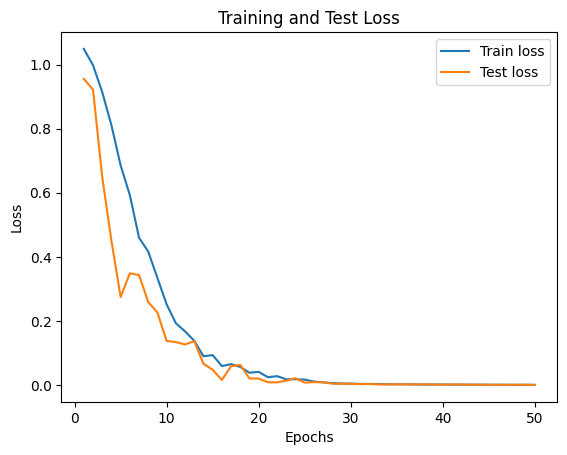

In [59]:
epochs = range(1, epochs + 1)
plt.plot(epochs, train_losses, label='Train loss')
plt.plot(epochs, test_losses,label='Test loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Test Loss")
plt.legend()
plt.show()

In [65]:
import torch
from PIL import Image
from torchvision import transforms

# Load the TorchScript model
model = torch.jit.load('final_model_scripted.pth')

def predict_image(model, image_path, transform):
    model.eval()  # Set the model to evaluation mode
    image = Image.open(image_path).convert('RGB')  # Ensure the image is in RGB mode
    image = transform(image).unsqueeze(0)  # Apply transform and add batch dimension

    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)
    
    return predicted.item()

# Define the image transform
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

image_paths = ['./drawing(59).png', './drawing(8).png', './Circle.png']  # Add more images representing each class

for img_path in image_paths:
    predicted_class = predict_image(model, img_path, transform)
    print(f"Predicted class for {img_path}: {predicted_class}")

Predicted class for ./drawing(59).png: 0
Predicted class for ./drawing(8).png: 0
Predicted class for ./Circle.png: 0
